# Starbucks Capstone Challenge

### Introduction

This data set contains simulated data that mimics customer behavior on the Starbucks rewards mobile app. Once every few days, Starbucks sends out an offer to users of the mobile app. An offer can be merely an advertisement for a drink or an actual offer such as a discount or BOGO (buy one get one free). Some users might not receive any offer during certain weeks. 

Not all users receive the same offer, and that is the challenge to solve with this data set.

Your task is to combine transaction, demographic and offer data to determine which demographic groups respond best to which offer type. This data set is a simplified version of the real Starbucks app because the underlying simulator only has one product whereas Starbucks actually sells dozens of products.

Every offer has a validity period before the offer expires. As an example, a BOGO offer might be valid for only 5 days. You'll see in the data set that informational offers have a validity period even though these ads are merely providing information about a product; for example, if an informational offer has 7 days of validity, you can assume the customer is feeling the influence of the offer for 7 days after receiving the advertisement.

You'll be given transactional data showing user purchases made on the app including the timestamp of purchase and the amount of money spent on a purchase. This transactional data also has a record for each offer that a user receives as well as a record for when a user actually views the offer. There are also records for when a user completes an offer. 

Keep in mind as well that someone using the app might make a purchase through the app without having received an offer or seen an offer.

### Example

To give an example, a user could receive a discount offer buy 10 dollars get 2 off on Monday. The offer is valid for 10 days from receipt. If the customer accumulates at least 10 dollars in purchases during the validity period, the customer completes the offer.

However, there are a few things to watch out for in this data set. Customers do not opt into the offers that they receive; in other words, a user can receive an offer, never actually view the offer, and still complete the offer. For example, a user might receive the "buy 10 dollars get 2 dollars off offer", but the user never opens the offer during the 10 day validity period. The customer spends 15 dollars during those ten days. There will be an offer completion record in the data set; however, the customer was not influenced by the offer because the customer never viewed the offer.

### Cleaning

This makes data cleaning especially important and tricky.

You'll also want to take into account that some demographic groups will make purchases even if they don't receive an offer. From a business perspective, if a customer is going to make a 10 dollar purchase without an offer anyway, you wouldn't want to send a buy 10 dollars get 2 dollars off offer. You'll want to try to assess what a certain demographic group will buy when not receiving any offers.

### Final Advice

Because this is a capstone project, you are free to analyze the data any way you see fit. For example, you could build a machine learning model that predicts how much someone will spend based on demographics and offer type. Or you could build a model that predicts whether or not someone will respond to an offer. Or, you don't need to build a machine learning model at all. You could develop a set of heuristics that determine what offer you should send to each customer (ie 75 percent of women customers who were 35 years old responded to offer A vs 40 percent from the same demographic to offer B, so send offer A).

# Data Sets

The data is contained in three files:

* portfolio.json - containing offer ids and meta data about each offer (duration, type, etc.)
* profile.json - demographic data for each customer
* transcript.json - records for transactions, offers received, offers viewed, and offers completed

Here is the schema and explanation of each variable in the files:

**portfolio.json**
* id (string) - offer id
* offer_type (string) - type of offer ie BOGO, discount, informational
* difficulty (int) - minimum required spend to complete an offer
* reward (int) - reward given for completing an offer
* duration (int) - 
* channels (list of strings)

**profile.json**
* age (int) - age of the customer 
* became_member_on (int) - date when customer created an app account
* gender (str) - gender of the customer (note some entries contain 'O' for other rather than M or F)
* id (str) - customer id
* income (float) - customer's income

**transcript.json**
* event (str) - record description (ie transaction, offer received, offer viewed, etc.)
* person (str) - customer id
* time (int) - time in hours. The data begins at time t=0
* value - (dict of strings) - either an offer id or transaction amount depending on the record

**Note:** If you are using the workspace, you will need to go to the terminal and run the command `conda update pandas` before reading in the files. This is because the version of pandas in the workspace cannot read in the transcript.json file correctly, but the newest version of pandas can. You can access the termnal from the orange icon in the top left of this notebook.  

You can see how to access the terminal and how the install works using the two images below.  First you need to access the terminal:

<img src="pic1.png"/>

Then you will want to run the above command:

<img src="pic2.png"/>

Finally, when you enter back into the notebook (use the jupyter icon again), you should be able to run the below cell without any errors.

In [1]:
import pandas as pd
import numpy as np
import math
import json
import seaborn as sns
import matplotlib.pyplot as plt
% matplotlib inline

# read in the json files
portfolio = pd.read_json('data/portfolio.json', orient='records', lines=True)
profile = pd.read_json('data/profile.json', orient='records', lines=True)
transcript = pd.read_json('data/transcript.json', orient='records', lines=True)

# Data Understanding & Cleaning

## 1. Portfolio

In [2]:
#provide portfolio name instead of id for interpretation later on

def add_portfolio_name(portfolio_df):
    portfolio_df['name'] = portfolio_df.offer_type.astype(str) + "_" + portfolio_df.difficulty.astype(str) +\
                      "_" + portfolio_df.reward.astype(str) + \
                     "_" + portfolio_df.duration.astype(str)
    return portfolio_df

add_portfolio_name(portfolio)

,channels,difficulty,duration,id,offer_type,reward,name
0,"[email, mobile, social]",10,7,ae264e3637204a6fb9bb56bc8210ddfd,bogo,10,bogo_10_10_7
1,"[web, email, mobile, social]",10,5,4d5c57ea9a6940dd891ad53e9dbe8da0,bogo,10,bogo_10_10_5
2,"[web, email, mobile]",0,4,3f207df678b143eea3cee63160fa8bed,informational,0,informational_0_0_4
3,"[web, email, mobile]",5,7,9b98b8c7a33c4b65b9aebfe6a799e6d9,bogo,5,bogo_5_5_7
4,"[web, email]",20,10,0b1e1539f2cc45b7b9fa7c272da2e1d7,discount,5,discount_20_5_10
5,"[web, email, mobile, social]",7,7,2298d6c36e964ae4a3e7e9706d1fb8c2,discount,3,discount_7_3_7
6,"[web, email, mobile, social]",10,10,fafdcd668e3743c1bb461111dcafc2a4,discount,2,discount_10_2_10
7,"[email, mobile, social]",0,3,5a8bc65990b245e5a138643cd4eb9837,informational,0,informational_0_0_3
8,"[web, email, mobile, social]",5,5,f19421c1d4aa40978ebb69ca19b0e20d,bogo,5,bogo_5_5_5
9,"[web, email, mobile]",10,7,2906b810c7d4411798c6938adc9daaa5,discount,2,discount_10_2_7


In [3]:
portfolio['name'] = portfolio.offer_type.astype(str) + "_" + portfolio.difficulty.astype(str) + "_" + portfolio.reward.astype(str) \
                    + "_" + portfolio.duration.astype(str)

In [4]:
portfolio

,channels,difficulty,duration,id,offer_type,reward,name
0,"[email, mobile, social]",10,7,ae264e3637204a6fb9bb56bc8210ddfd,bogo,10,bogo_10_10_7
1,"[web, email, mobile, social]",10,5,4d5c57ea9a6940dd891ad53e9dbe8da0,bogo,10,bogo_10_10_5
2,"[web, email, mobile]",0,4,3f207df678b143eea3cee63160fa8bed,informational,0,informational_0_0_4
3,"[web, email, mobile]",5,7,9b98b8c7a33c4b65b9aebfe6a799e6d9,bogo,5,bogo_5_5_7
4,"[web, email]",20,10,0b1e1539f2cc45b7b9fa7c272da2e1d7,discount,5,discount_20_5_10
5,"[web, email, mobile, social]",7,7,2298d6c36e964ae4a3e7e9706d1fb8c2,discount,3,discount_7_3_7
6,"[web, email, mobile, social]",10,10,fafdcd668e3743c1bb461111dcafc2a4,discount,2,discount_10_2_10
7,"[email, mobile, social]",0,3,5a8bc65990b245e5a138643cd4eb9837,informational,0,informational_0_0_3
8,"[web, email, mobile, social]",5,5,f19421c1d4aa40978ebb69ca19b0e20d,bogo,5,bogo_5_5_5
9,"[web, email, mobile]",10,7,2906b810c7d4411798c6938adc9daaa5,discount,2,discount_10_2_7


In [4]:
def one_hot_channels(portfolio_df):
    
    channels = ['web', 'email', 'mobile', 'social']

    for channel in channels:
        portfolio_df[channel] = portfolio_df.channels.apply(lambda x: channel in x)*1

    #drop channels column
    portfolio_df = portfolio_df.drop('channels', axis=1)
    
    return portfolio_df

one_hot_channels(portfolio)

,difficulty,duration,id,offer_type,reward,name,web,email,mobile,social
0,10,7,ae264e3637204a6fb9bb56bc8210ddfd,bogo,10,bogo_10_10_7,0,1,1,1
1,10,5,4d5c57ea9a6940dd891ad53e9dbe8da0,bogo,10,bogo_10_10_5,1,1,1,1
2,0,4,3f207df678b143eea3cee63160fa8bed,informational,0,informational_0_0_4,1,1,1,0
3,5,7,9b98b8c7a33c4b65b9aebfe6a799e6d9,bogo,5,bogo_5_5_7,1,1,1,0
4,20,10,0b1e1539f2cc45b7b9fa7c272da2e1d7,discount,5,discount_20_5_10,1,1,0,0
5,7,7,2298d6c36e964ae4a3e7e9706d1fb8c2,discount,3,discount_7_3_7,1,1,1,1
6,10,10,fafdcd668e3743c1bb461111dcafc2a4,discount,2,discount_10_2_10,1,1,1,1
7,0,3,5a8bc65990b245e5a138643cd4eb9837,informational,0,informational_0_0_3,0,1,1,1
8,5,5,f19421c1d4aa40978ebb69ca19b0e20d,bogo,5,bogo_5_5_5,1,1,1,1
9,10,7,2906b810c7d4411798c6938adc9daaa5,discount,2,discount_10_2_7,1,1,1,0


In [5]:
## One hot 'channels' column

channels = ['web', 'email', 'mobile', 'social']

for channel in channels:
    portfolio[channel] = portfolio.channels.apply(lambda x: channel in x)*1
    
#drop channels column
portfolio = portfolio.drop('channels', axis=1)
portfolio

,difficulty,duration,id,offer_type,reward,name,web,email,mobile,social
0,10,7,ae264e3637204a6fb9bb56bc8210ddfd,bogo,10,bogo_10_10_7,0,1,1,1
1,10,5,4d5c57ea9a6940dd891ad53e9dbe8da0,bogo,10,bogo_10_10_5,1,1,1,1
2,0,4,3f207df678b143eea3cee63160fa8bed,informational,0,informational_0_0_4,1,1,1,0
3,5,7,9b98b8c7a33c4b65b9aebfe6a799e6d9,bogo,5,bogo_5_5_7,1,1,1,0
4,20,10,0b1e1539f2cc45b7b9fa7c272da2e1d7,discount,5,discount_20_5_10,1,1,0,0
5,7,7,2298d6c36e964ae4a3e7e9706d1fb8c2,discount,3,discount_7_3_7,1,1,1,1
6,10,10,fafdcd668e3743c1bb461111dcafc2a4,discount,2,discount_10_2_10,1,1,1,1
7,0,3,5a8bc65990b245e5a138643cd4eb9837,informational,0,informational_0_0_3,0,1,1,1
8,5,5,f19421c1d4aa40978ebb69ca19b0e20d,bogo,5,bogo_5_5_5,1,1,1,1
9,10,7,2906b810c7d4411798c6938adc9daaa5,discount,2,discount_10_2_7,1,1,1,0


In [4]:
portfolio.offer_type.value_counts()#.plot(kind='bar')

bogo             4
discount         4
informational    2
Name: offer_type, dtype: int64

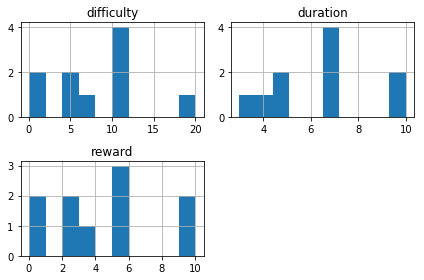

In [5]:
portfolio[['difficulty', 'reward', 'duration']].hist();
plt.tight_layout()

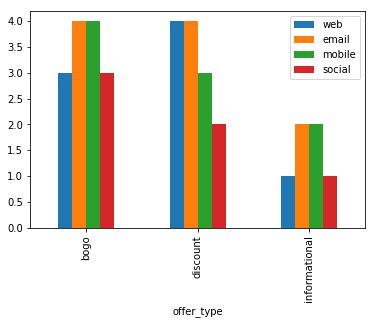

In [6]:
portfolio.groupby('offer_type').sum()[channels].plot(kind='bar')

## 2. Profile

In [7]:
profile.head()

,age,became_member_on,gender,id,income
0,118,20170212,None,68be06ca386d4c31939f3a4f0e3dd783,NaN
1,55,20170715,F,0610b486422d4921ae7d2bf64640c50b,112000.0
2,118,20180712,None,38fe809add3b4fcf9315a9694bb96ff5,NaN
3,75,20170509,F,78afa995795e4d85b5d9ceeca43f5fef,100000.0
4,118,20170804,None,a03223e636434f42ac4c3df47e8bac43,NaN


In [20]:
profile.describe()

,age,income
count,17000.000000,14825.000000
mean,62.531412,65404.991568
std,26.738580,21598.299410
min,18.000000,30000.000000
25%,45.000000,49000.000000
50%,58.000000,64000.000000
75%,73.000000,80000.000000
max,118.000000,120000.000000


### 2.1 Parsing Dates

In [6]:
#parse dates

def profile_parse_dates(profile_df):
    profile_df = profile_df.copy()
    
    #convert to string
    profile_df['became_member_on'] = profile_df.became_member_on.apply(lambda x: str(x))
    #convert to datetime format
    profile_df['became_member_on'] = pd.to_datetime(profile_df.became_member_on, format='%Y%m%d')
    return profile_df

profile_parse_dates(profile)

,age,became_member_on,gender,id,income
0,118,2017-02-12,None,68be06ca386d4c31939f3a4f0e3dd783,NaN
1,55,2017-07-15,F,0610b486422d4921ae7d2bf64640c50b,112000.0
2,118,2018-07-12,None,38fe809add3b4fcf9315a9694bb96ff5,NaN
3,75,2017-05-09,F,78afa995795e4d85b5d9ceeca43f5fef,100000.0
4,118,2017-08-04,None,a03223e636434f42ac4c3df47e8bac43,NaN
5,68,2018-04-26,M,e2127556f4f64592b11af22de27a7932,70000.0
6,118,2017-09-25,None,8ec6ce2a7e7949b1bf142def7d0e0586,NaN
7,118,2017-10-02,None,68617ca6246f4fbc85e91a2a49552598,NaN
8,65,2018-02-09,M,389bc3fa690240e798340f5a15918d5c,53000.0
9,118,2016-11-22,None,8974fc5686fe429db53ddde067b88302,NaN


In [8]:
#parse dates

#convert to string
profile['became_member_on'] = profile.became_member_on.apply(lambda x: str(x))
#convert to datetime format
profile['became_member_on'] = pd.to_datetime(profile.became_member_on, format='%Y%m%d')

In [9]:
profile.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17000 entries, 0 to 16999
Data columns (total 5 columns):
age                 17000 non-null int64
became_member_on    17000 non-null datetime64[ns]
gender              14825 non-null object
id                  17000 non-null object
income              14825 non-null float64
dtypes: datetime64[ns](1), float64(1), int64(1), object(2)
memory usage: 664.1+ KB


### 2.2 Missing Values

In [60]:
profile.isnull().sum()

age                    0
became_member_on       0
gender              2175
id                     0
income              2175
dtype: int64

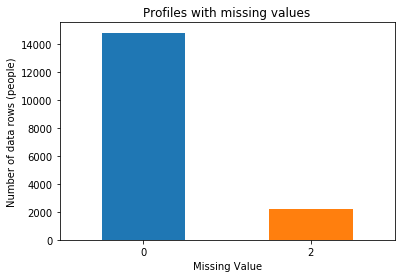

In [10]:
# How much data is missing in each row of the dataset?
row_null = profile.isnull().sum(axis=1)
row_null.value_counts().plot(kind='bar')
plt.xlabel('Missing Value')
plt.xticks(rotation=0)
plt.ylabel('Number of data rows (people)')
plt.title('Profiles with missing values')
plt.show()

In [7]:
row_null.value_counts()

0    14825
2     2175
dtype: int64

In [11]:
profile_ = profile[row_null ==0]
profile_null = profile[row_null > 0]

In [12]:
profile_.isnull().sum() *100 / profile_.shape[0]

age                 0.0
became_member_on    0.0
gender              0.0
id                  0.0
income              0.0
dtype: float64

In [13]:
profile_null.isnull().sum() *100 / profile_null.shape[0]

age                   0.0
became_member_on      0.0
gender              100.0
id                    0.0
income              100.0
dtype: float64

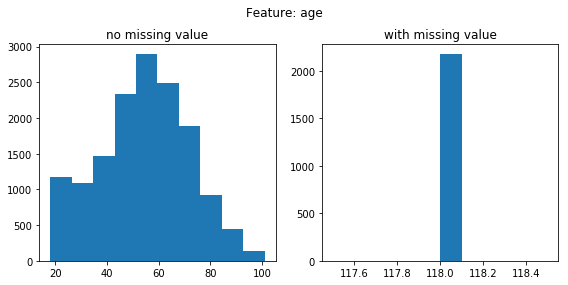

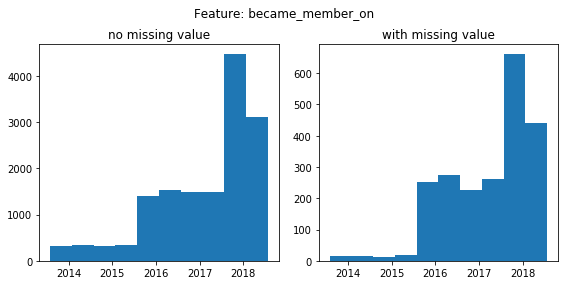

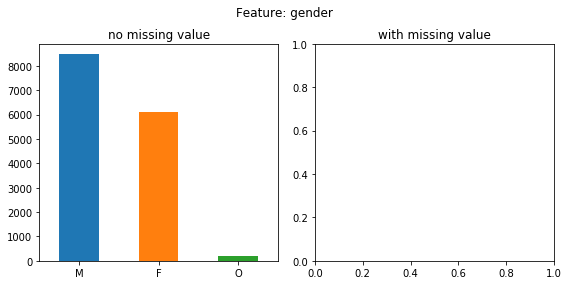

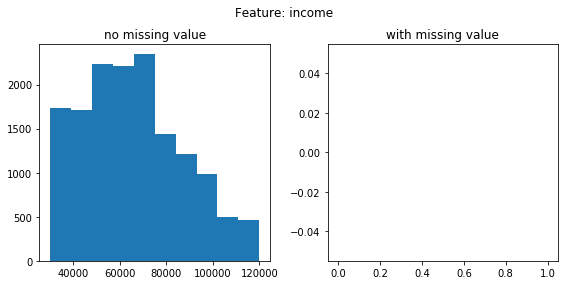

In [76]:
for col in ['age', 'became_member_on','gender', 'income' ]:
    row_null = profile.isnull().sum(axis=1)
    f, (ax1,ax2) = plt.subplots(1,2, figsize=(8,4))
   
    if col == 'gender':
        profile_[col].value_counts().plot(kind='bar', ax=ax1)
        ax1.set_xticklabels(ax1.xaxis.get_majorticklabels(),rotation=0)
        try :
            profile_null[col].value_counts().plot(kind='bar', ax=ax2)
            
        except:
            pass
    else:
        profile_[col].hist(ax=ax1)
        profile_null[col].hist(ax=ax2)
    
    ax1.grid(False)
    ax2.grid(False)
    ax1.set_title('no missing value' )
    ax2.set_title('with missing value')
    f.suptitle('Feature: ' + col)
    f.tight_layout()
    f.subplots_adjust(top=0.85)

Notes:
- All missing values in gender and income are correlated with age > 100 years, probably they don't want to share the informations. What about their spending pattern ?

### 2.6 Encoding Age
```
1 : age < 20
2 : 20 <= age < 30
3 : 30 <= age < 40
4 : 40 <= age < 50
5 : 50 <= age < 60
6 : 60 <= age < 70
7 : age >= 70
```

In [27]:
def encode_age(x):
    if x >= 70 :
        return 7
    elif x >= 60:
        return 6
    elif x >= 50:
        return 5
    elif x >=40:
        return 4
    elif x >=30:
        return 3
    elif x >= 20:
        return 2
    else:
        return 1
    

In [14]:
profile_cleaned['age_encoded'] = profile_cleaned.age.apply(encode_age)

NameError: name 'profile_cleaned' is not defined

In [34]:
profile_cleaned.head()

,age,became_member_on,gender,id,income,age_encoded
1,55,2017-07-15,F,0610b486422d4921ae7d2bf64640c50b,112000.0,5
3,75,2017-05-09,F,78afa995795e4d85b5d9ceeca43f5fef,100000.0,7
5,68,2018-04-26,M,e2127556f4f64592b11af22de27a7932,70000.0,6
8,65,2018-02-09,M,389bc3fa690240e798340f5a15918d5c,53000.0,6
12,58,2017-11-11,M,2eeac8d8feae4a8cad5a6af0499a211d,51000.0,5


In [36]:
profile_cleaned.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 14820 entries, 1 to 16999
Data columns (total 6 columns):
age                 14820 non-null int64
became_member_on    14820 non-null datetime64[ns]
gender              14820 non-null object
id                  14820 non-null object
income              14820 non-null float64
age_encoded         14820 non-null int64
dtypes: datetime64[ns](1), float64(1), int64(2), object(2)
memory usage: 810.5+ KB


## 3. Transcript

In [99]:
transcript.head()

,event,person,time,value
0,offer received,78afa995795e4d85b5d9ceeca43f5fef,0,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'}
1,offer received,a03223e636434f42ac4c3df47e8bac43,0,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'}
2,offer received,e2127556f4f64592b11af22de27a7932,0,{'offer id': '2906b810c7d4411798c6938adc9daaa5'}
3,offer received,8ec6ce2a7e7949b1bf142def7d0e0586,0,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'}
4,offer received,68617ca6246f4fbc85e91a2a49552598,0,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'}


In [100]:
transcript.isnull().sum()

event     0
person    0
time      0
value     0
dtype: int64

In [43]:
transcript.shape

(306534, 4)

In [15]:
def encode_offer_id(x):
    try :
        return x['offer id']
    except:
        return x['offer_id']


In [16]:
def transcript_encoded(transcript_df):
    transcript_encoded = transcript_df.copy()
    transcript_encoded['offer_id'] = transcript[transcript.event.isin(['offer received', 'offer viewed', 'offer completed'])]\
                                                             .value.apply(encode_offer_id)
    transcript_encoded['amount'] =  transcript[transcript.event.isin(['transaction'])].value.apply(lambda x: x['amount'])
    return transcript_encoded

transcript_encoded(transcript)

,event,person,time,value,offer_id,amount
0,offer received,78afa995795e4d85b5d9ceeca43f5fef,0,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},9b98b8c7a33c4b65b9aebfe6a799e6d9,NaN
1,offer received,a03223e636434f42ac4c3df47e8bac43,0,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},0b1e1539f2cc45b7b9fa7c272da2e1d7,NaN
2,offer received,e2127556f4f64592b11af22de27a7932,0,{'offer id': '2906b810c7d4411798c6938adc9daaa5'},2906b810c7d4411798c6938adc9daaa5,NaN
3,offer received,8ec6ce2a7e7949b1bf142def7d0e0586,0,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'},fafdcd668e3743c1bb461111dcafc2a4,NaN
4,offer received,68617ca6246f4fbc85e91a2a49552598,0,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'},4d5c57ea9a6940dd891ad53e9dbe8da0,NaN
5,offer received,389bc3fa690240e798340f5a15918d5c,0,{'offer id': 'f19421c1d4aa40978ebb69ca19b0e20d'},f19421c1d4aa40978ebb69ca19b0e20d,NaN
6,offer received,c4863c7985cf408faee930f111475da3,0,{'offer id': '2298d6c36e964ae4a3e7e9706d1fb8c2'},2298d6c36e964ae4a3e7e9706d1fb8c2,NaN
7,offer received,2eeac8d8feae4a8cad5a6af0499a211d,0,{'offer id': '3f207df678b143eea3cee63160fa8bed'},3f207df678b143eea3cee63160fa8bed,NaN
8,offer received,aa4862eba776480b8bb9c68455b8c2e1,0,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},0b1e1539f2cc45b7b9fa7c272da2e1d7,NaN
9,offer received,31dda685af34476cad5bc968bdb01c53,0,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},0b1e1539f2cc45b7b9fa7c272da2e1d7,NaN


In [19]:
transcript_encoded = transcript.copy()
transcript_encoded['offer_id'] = transcript[transcript.event.isin(['offer received', 'offer viewed', 'offer completed'])]\
                                                         .value.apply(encode_offer_id)
transcript_encoded['amount'] =  transcript[transcript.event.isin(['transaction'])].value.apply(lambda x: x['amount'])
transcript_encoded

,event,person,time,value,offer_id,amount
0,offer received,78afa995795e4d85b5d9ceeca43f5fef,0,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},9b98b8c7a33c4b65b9aebfe6a799e6d9,NaN
1,offer received,a03223e636434f42ac4c3df47e8bac43,0,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},0b1e1539f2cc45b7b9fa7c272da2e1d7,NaN
2,offer received,e2127556f4f64592b11af22de27a7932,0,{'offer id': '2906b810c7d4411798c6938adc9daaa5'},2906b810c7d4411798c6938adc9daaa5,NaN
3,offer received,8ec6ce2a7e7949b1bf142def7d0e0586,0,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'},fafdcd668e3743c1bb461111dcafc2a4,NaN
4,offer received,68617ca6246f4fbc85e91a2a49552598,0,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'},4d5c57ea9a6940dd891ad53e9dbe8da0,NaN
5,offer received,389bc3fa690240e798340f5a15918d5c,0,{'offer id': 'f19421c1d4aa40978ebb69ca19b0e20d'},f19421c1d4aa40978ebb69ca19b0e20d,NaN
6,offer received,c4863c7985cf408faee930f111475da3,0,{'offer id': '2298d6c36e964ae4a3e7e9706d1fb8c2'},2298d6c36e964ae4a3e7e9706d1fb8c2,NaN
7,offer received,2eeac8d8feae4a8cad5a6af0499a211d,0,{'offer id': '3f207df678b143eea3cee63160fa8bed'},3f207df678b143eea3cee63160fa8bed,NaN
8,offer received,aa4862eba776480b8bb9c68455b8c2e1,0,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},0b1e1539f2cc45b7b9fa7c272da2e1d7,NaN
9,offer received,31dda685af34476cad5bc968bdb01c53,0,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},0b1e1539f2cc45b7b9fa7c272da2e1d7,NaN


### 3.1 Probability / Distribution portfolio sent by startbuck

(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]), <a list of 10 Text xticklabel objects>)

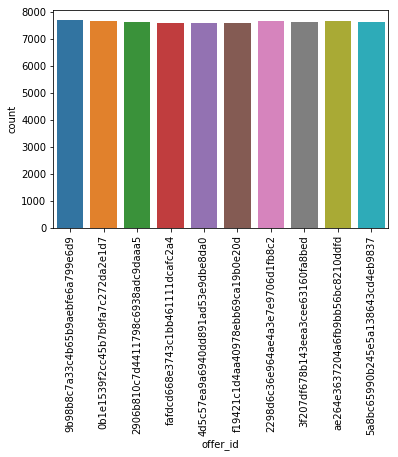

In [103]:
received = transcript_encoded[transcript_encoded.event =='offer received']

sns.countplot(received['offer_id'])
plt.xticks(rotation=90)

### 3.2 Customer Spending Distribution 

count    16578.000000
mean        13.680266
std         16.056763
min          0.050000
25%          3.181392
50%         11.996607
75%         20.469643
max        451.470000
Name: amount, dtype: float64

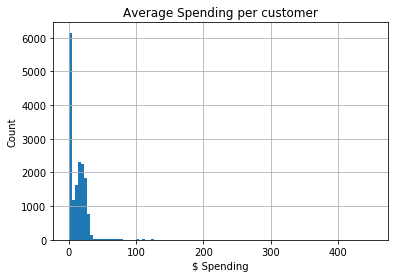

In [267]:
transcript_encoded.groupby('person')['amount'].mean().hist(bins=100)
plt.xlabel('$ Spending')
plt.ylabel('Count')
plt.title('Average Spending per customer')
transcript_encoded.groupby('person')['amount'].mean().describe()

count    17000.000000
mean         8.173706
std          5.116250
min          0.000000
25%          4.000000
50%          7.000000
75%         11.000000
max         36.000000
Name: amount, dtype: float64

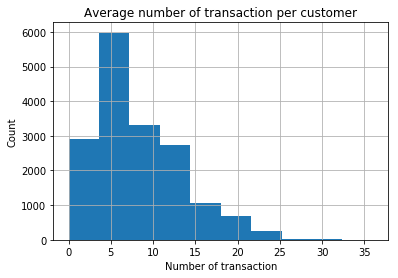

In [270]:
transcript_encoded.groupby('person')['amount'].count().hist()
plt.xlabel('Number of transaction')
plt.ylabel('Count')
plt.title('Average number of transaction per customer')
transcript_encoded.groupby('person')['amount'].count().describe()

In [18]:
def merge_transcript_profile(transcript_df, profile_df):
    transcript_encoded_df = transcript_encoded(transcript_df)
    transcript_profile_df = pd.merge(transcript_encoded_df, profile_df, left_on=['person'], 
                                      right_on = ['id'], how ='left')
    transcript_profile_df = transcript_profile_df.drop(['id'], axis=1)
    
    return transcript_profile_df
merge_transcript_profile(transcript, profile)

TypeError: 'DataFrame' object is not callable

In [20]:
transcript_profile = pd.merge(transcript_encoded, profile, left_on=['person'], 
                                      right_on = ['id'],
                                      how ='left')
transcript_profile = transcript_profile.drop(['id'], axis=1)
transcript_profile.head()

,event,person,time,value,offer_id,amount,age,became_member_on,gender,income
0,offer received,78afa995795e4d85b5d9ceeca43f5fef,0,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},9b98b8c7a33c4b65b9aebfe6a799e6d9,NaN,75,2017-05-09,F,100000.0
1,offer received,a03223e636434f42ac4c3df47e8bac43,0,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},0b1e1539f2cc45b7b9fa7c272da2e1d7,NaN,118,2017-08-04,None,NaN
2,offer received,e2127556f4f64592b11af22de27a7932,0,{'offer id': '2906b810c7d4411798c6938adc9daaa5'},2906b810c7d4411798c6938adc9daaa5,NaN,68,2018-04-26,M,70000.0
3,offer received,8ec6ce2a7e7949b1bf142def7d0e0586,0,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'},fafdcd668e3743c1bb461111dcafc2a4,NaN,118,2017-09-25,None,NaN
4,offer received,68617ca6246f4fbc85e91a2a49552598,0,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'},4d5c57ea9a6940dd891ad53e9dbe8da0,NaN,118,2017-10-02,None,NaN


Text(0.5,1,'Average $ Spending')

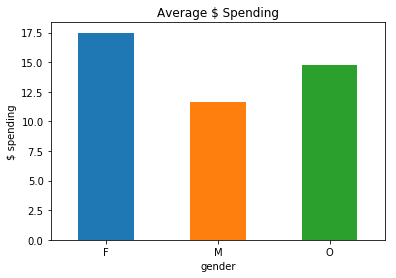

In [278]:
transcript_profile.groupby('gender')['amount'].mean().plot(kind='bar')
plt.xticks(rotation=0)
plt.ylabel("$ spending")
plt.title("Average $ Spending")

### 3.3 Reviewed & Completed Rate

In [35]:
def portfolio_preprocessing(portfolio_df):
    # add portfolio add_portfolio_name
    portfolio_df = add_portfolio_name(portfolio_df)
    # one_hot_channels
    portfolio_df = one_hot_channels(portfolio_df)
    return portfolio_df

def merge_transcript_profile_portfolio(transcript_df, profile_df, portfolio_df):
    portfolio_df = portfolio_preprocessing(portfolio_df)
    transcript_profile_df = merge_transcript_profile(transcript_df, profile_df)
    transcript_profile_porto = pd.merge(transcript_profile_df, portfolio_df, left_on = 'offer_id', right_on ='id', how='left').drop('id', axis=1)
    return transcript_profile_porto

merge_transcript_profile_portfolio(transcript, profile, portfolio)

,event,person,time,value,offer_id,amount,age,became_member_on,gender,income,difficulty,duration,offer_type,reward,name,web,email,mobile,social
0,offer received,78afa995795e4d85b5d9ceeca43f5fef,0,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},9b98b8c7a33c4b65b9aebfe6a799e6d9,NaN,75,2017-05-09,F,100000.0,5.0,7.0,bogo,5.0,bogo_5_5_7,1.0,1.0,1.0,0.0
1,offer received,a03223e636434f42ac4c3df47e8bac43,0,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},0b1e1539f2cc45b7b9fa7c272da2e1d7,NaN,118,2017-08-04,None,NaN,20.0,10.0,discount,5.0,discount_20_5_10,1.0,1.0,0.0,0.0
2,offer received,e2127556f4f64592b11af22de27a7932,0,{'offer id': '2906b810c7d4411798c6938adc9daaa5'},2906b810c7d4411798c6938adc9daaa5,NaN,68,2018-04-26,M,70000.0,10.0,7.0,discount,2.0,discount_10_2_7,1.0,1.0,1.0,0.0
3,offer received,8ec6ce2a7e7949b1bf142def7d0e0586,0,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'},fafdcd668e3743c1bb461111dcafc2a4,NaN,118,2017-09-25,None,NaN,10.0,10.0,discount,2.0,discount_10_2_10,1.0,1.0,1.0,1.0
4,offer received,68617ca6246f4fbc85e91a2a49552598,0,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'},4d5c57ea9a6940dd891ad53e9dbe8da0,NaN,118,2017-10-02,None,NaN,10.0,5.0,bogo,10.0,bogo_10_10_5,1.0,1.0,1.0,1.0
5,offer received,389bc3fa690240e798340f5a15918d5c,0,{'offer id': 'f19421c1d4aa40978ebb69ca19b0e20d'},f19421c1d4aa40978ebb69ca19b0e20d,NaN,65,2018-02-09,M,53000.0,5.0,5.0,bogo,5.0,bogo_5_5_5,1.0,1.0,1.0,1.0
6,offer received,c4863c7985cf408faee930f111475da3,0,{'offer id': '2298d6c36e964ae4a3e7e9706d1fb8c2'},2298d6c36e964ae4a3e7e9706d1fb8c2,NaN,118,2017-08-24,None,NaN,7.0,7.0,discount,3.0,discount_7_3_7,1.0,1.0,1.0,1.0
7,offer received,2eeac8d8feae4a8cad5a6af0499a211d,0,{'offer id': '3f207df678b143eea3cee63160fa8bed'},3f207df678b143eea3cee63160fa8bed,NaN,58,2017-11-11,M,51000.0,0.0,4.0,informational,0.0,informational_0_0_4,1.0,1.0,1.0,0.0
8,offer received,aa4862eba776480b8bb9c68455b8c2e1,0,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},0b1e1539f2cc45b7b9fa7c272da2e1d7,NaN,61,2017-09-11,F,57000.0,20.0,10.0,discount,5.0,discount_20_5_10,1.0,1.0,0.0,0.0
9,offer received,31dda685af34476cad5bc968bdb01c53,0,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},0b1e1539f2cc45b7b9fa7c272da2e1d7,NaN,62,2016-02-11,F,71000.0,20.0,10.0,discount,5.0,discount_20_5_10,1.0,1.0,0.0,0.0


In [21]:
transcript_profile_porto = pd.merge(transcript_profile, portfolio, left_on = 'offer_id', right_on ='id', how='left').drop('id', axis=1)
transcript_profile_porto.head()

,event,person,time,value,offer_id,amount,age,became_member_on,gender,income,difficulty,duration,offer_type,reward,name,web,email,mobile,social
0,offer received,78afa995795e4d85b5d9ceeca43f5fef,0,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},9b98b8c7a33c4b65b9aebfe6a799e6d9,NaN,75,2017-05-09,F,100000.0,5.0,7.0,bogo,5.0,bogo_5_5_7,1.0,1.0,1.0,0.0
1,offer received,a03223e636434f42ac4c3df47e8bac43,0,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},0b1e1539f2cc45b7b9fa7c272da2e1d7,NaN,118,2017-08-04,None,NaN,20.0,10.0,discount,5.0,discount_20_5_10,1.0,1.0,0.0,0.0
2,offer received,e2127556f4f64592b11af22de27a7932,0,{'offer id': '2906b810c7d4411798c6938adc9daaa5'},2906b810c7d4411798c6938adc9daaa5,NaN,68,2018-04-26,M,70000.0,10.0,7.0,discount,2.0,discount_10_2_7,1.0,1.0,1.0,0.0
3,offer received,8ec6ce2a7e7949b1bf142def7d0e0586,0,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'},fafdcd668e3743c1bb461111dcafc2a4,NaN,118,2017-09-25,None,NaN,10.0,10.0,discount,2.0,discount_10_2_10,1.0,1.0,1.0,1.0
4,offer received,68617ca6246f4fbc85e91a2a49552598,0,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'},4d5c57ea9a6940dd891ad53e9dbe8da0,NaN,118,2017-10-02,None,NaN,10.0,5.0,bogo,10.0,bogo_10_10_5,1.0,1.0,1.0,1.0


Text(0.5,1,'Portfolio Distribution')

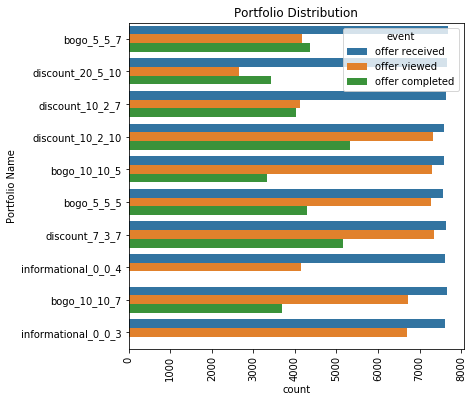

In [285]:
plt.figure(figsize=(6,6))
sns.countplot(y='name', hue='event', data=transcript_profile_porto[~transcript_profile_porto.event.isin(['transaction'])]);
plt.xticks(rotation=90)
plt.ylabel("Portfolio Name")
plt.title("Portfolio Distribution")

Notes:
- The number of offer received by customer was similar for all portfolio
- Discount_20_5_10 appeared to have higher offer completed than offer viewed. It means that the transaction was not due to offer. Need to be clean out or separate  for further analysis to assess what a certain demographic group will buy when not receiving any offers.

#### 3.3.1 Data cleaning to find the reviewed and completed rate 

In [44]:
from tqdm import tqdm

def find_invalid_index(transcript_df, profile_df, portfolio_df):
    trascript_merge_df = merge_transcript_profile_portfolio(transcript_df, profile_df, portfolio_df)

    # list of invalid index of offer completed
    invalid_index = []

    #iterate over profile_id (person)
    for profile_id in tqdm(trascript_merge_df.person.unique()):
        # take a subest_df for profile_id person
        subset_df = trascript_merge_df[trascript_merge_df.person == profile_id]
        # take a subset of 'offer completed'
        completed_df = subset_df[subset_df.event == 'offer completed']

        # iterate over the completed offer_id
        for offer in completed_df.offer_id.unique():
            # take a subset df of completed offer
            comp = completed_df[completed_df.offer_id == offer]
            # estimate the offer received time in hours using the offer duration (in days)
            start_time = comp.time.values - (comp.duration.values *24)
            # the offer completed time
            comp_time = comp.time.values
            # take the subset within start_time and comp_time
            subset = subset_df[(subset_df.time >= start_time[0]) & (subset_df.time <= comp.time.values[0])]
            # take only event of offer viewed for the given offer_id
            subset_viewed = subset[(subset.event == 'offer viewed') & ( subset.offer_id == offer)]

            # check whether subset_viewed is empty or not, if it is empty then the offer completed is not valid 
            # because the offer is completed before the customer viewed it, 
            # it means  that the customer was not affected by the portfolio campaign
            if subset_viewed.shape[0] == 0 :
                invalid_index.extend(comp.index)
    
    return invalid_index
find_invalid_index(transcript, profile, portfolio)

  0%|          | 61/17000 [00:01<07:04, 39.90it/s]


KeyboardInterrupt: 

In [107]:
from tqdm import tqdm

# list of invalid index of offer completed
invalid_index = []

#iterate over profile_id (person)
for profile_id in tqdm(transcript_profile_porto.person.unique()):
    # take a subest_df for profile_id person
    subset_df = transcript_profile_porto[transcript_profile_porto.person == profile_id]
    # take a subset of 'offer completed'
    completed_df = subset_df[subset_df.event == 'offer completed']

    # iterate over the completed offer_id
    for offer in completed_df.offer_id.unique():
        # take a subset df of completed offer
        comp = completed_df[completed_df.offer_id == offer]
        # estimate the offer received time in hours using the offer duration (in days)
        start_time = comp.time.values - (comp.duration.values *24)
        # the offer completed time
        comp_time = comp.time.values
        # take the subset within start_time and comp_time
        subset = subset_df[(subset_df.time >= start_time[0]) & (subset_df.time <= comp.time.values[0])]
        # take only event of offer viewed for the given offer_id
        subset_viewed = subset[(subset.event == 'offer viewed') & ( subset.offer_id == offer)]
        
        # check whether subset_viewed is empty or not, if it is empty then the offer completed is not valid 
        # because the offer is completed before the customer viewed it, 
        # it means  that the customer was not affected by the portfolio campaign
        if subset_viewed.shape[0] == 0 :
            invalid_index.extend(comp.index)

100%|██████████| 17000/17000 [06:38<00:00, 47.40it/s]


In [108]:
# The number of 'offer completed' that are not influenced by the offer (the customer never viewed the offer when purchasing)
len(invalid_index)

9477

In [45]:
def transcript_preprocessing(transcript_df, profile_df, portfolio_df):
    trascript_merge_df = merge_transcript_profile_portfolio(transcript_df, profile_df, portfolio_df)
    invalid_index = find_invalid_index(transcript_df, profile_df, portfolio_df)
    transcript_clean_df = transcript_merge_df.loc[~transcript_merge_df.index.isin(invalid_index),:]
    return transcript_clean_df

transcript_preprocessing(transcript, profile, portfolio)

  1%|          | 164/17000 [00:04<06:55, 40.54it/s]


KeyboardInterrupt: 

In [109]:
# remove the invalid index
transcript_clean = transcript_profile_porto.loc[~transcript_profile_porto.index.isin(invalid_index),:]

In [110]:
#save clean transcript
transcript_clean.to_csv('transcript_clean.csv')

In [14]:
# read transcript clean
transcript_clean = pd.read_csv('transcript_clean.csv')#.set_index([0])
transcript_clean = transcript_clean.set_index(transcript_clean.columns[0])
transcript_clean.head()

,event,person,time,value,offer_id,amount,age,became_member_on,gender,income,channels,difficulty,duration,offer_type,reward,name
Unnamed: 0,,,,,,,,,,,,,,,,
0,offer received,78afa995795e4d85b5d9ceeca43f5fef,0,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},9b98b8c7a33c4b65b9aebfe6a799e6d9,NaN,75,2017-05-09,F,100000.0,"['web', 'email', 'mobile']",5.0,7.0,bogo,5.0,bogo_5_5
1,offer received,a03223e636434f42ac4c3df47e8bac43,0,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},0b1e1539f2cc45b7b9fa7c272da2e1d7,NaN,118,2017-08-04,NaN,NaN,"['web', 'email']",20.0,10.0,discount,5.0,discount_20_5
2,offer received,e2127556f4f64592b11af22de27a7932,0,{'offer id': '2906b810c7d4411798c6938adc9daaa5'},2906b810c7d4411798c6938adc9daaa5,NaN,68,2018-04-26,M,70000.0,"['web', 'email', 'mobile']",10.0,7.0,discount,2.0,discount_10_2
3,offer received,8ec6ce2a7e7949b1bf142def7d0e0586,0,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'},fafdcd668e3743c1bb461111dcafc2a4,NaN,118,2017-09-25,NaN,NaN,"['web', 'email', 'mobile', 'social']",10.0,10.0,discount,2.0,discount_10_2
4,offer received,68617ca6246f4fbc85e91a2a49552598,0,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'},4d5c57ea9a6940dd891ad53e9dbe8da0,NaN,118,2017-10-02,NaN,NaN,"['web', 'email', 'mobile', 'social']",10.0,5.0,bogo,10.0,bogo_10_10


In [111]:
event_count = transcript_clean.groupby(['name', 'event']).size().unstack()
event_count['offer_received_frac'] = event_count['offer received']/ event_count['offer received']
event_count['offer_viewed_frac'] = event_count['offer viewed']/ event_count['offer received']
event_count['offer_completed_frac'] =  event_count['offer completed']/ event_count['offer received']

event_count_frac = event_count[['offer_received_frac','offer_viewed_frac', 'offer_completed_frac']]
event_count_frac.reset_index()

event,name,offer_received_frac,offer_viewed_frac,offer_completed_frac
0,bogo_10_10_5,1.0,0.961148,0.369946
1,bogo_10_10_7,1.0,0.876991,0.352964
2,bogo_5_5_5,1.0,0.959451,0.471536
3,bogo_5_5_7,1.0,0.543311,0.287091
4,discount_10_2_10,1.0,0.964460,0.623404
5,discount_10_2_7,1.0,0.539570,0.288391
6,discount_20_5_10,1.0,0.347287,0.184924
7,discount_7_3_7,1.0,0.959587,0.583442
8,informational_0_0_3,1.0,0.877789,NaN
9,informational_0_0_4,1.0,0.544046,NaN


C:\Users\user\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


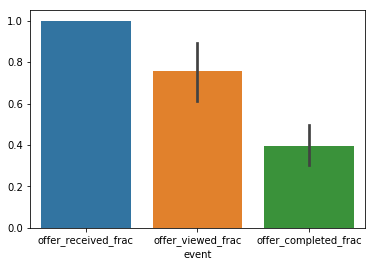

In [343]:
sns.barplot(data=event_count_frac)

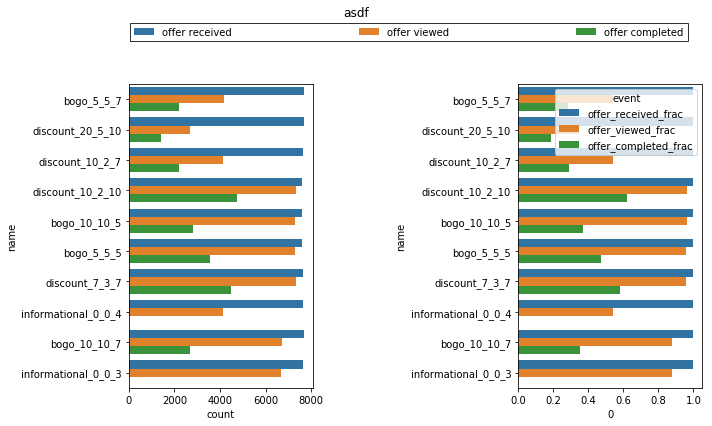

In [333]:
f, (ax1, ax2) = plt.subplots(1,2,figsize=(10,6))
sns.countplot(y='name', hue='event', data=transcript_clean[~transcript_clean.event.isin(['transaction'])], ax=ax1)


event_count_stack = event_count_frac.stack().reset_index()

labels = [item.get_text() for item in ax1.get_yticklabels()]
sns.barplot(x=0,y='name', hue='event', data=event_count_stack, ax=ax2, order=labels)
#ax1.legend(bbox_to_anchor=(0., 1.02, 2.2, .102), loc=3,
 #              ncol=4, mode="expand", borderaxespad=0)

s = f.subplotpars
bb=[s.left+0.06, s.top+0.02, s.right-s.left, 0.05 ]    
ax1.legend(loc=8, bbox_to_anchor=bb, ncol= 4, mode="expand", borderaxespad=0,
                bbox_transform=f.transFigure, fancybox=False, edgecolor="k")

#ax2.legend()
f.tight_layout()
f.subplots_adjust(top=0.8)
f.suptitle("asdf");


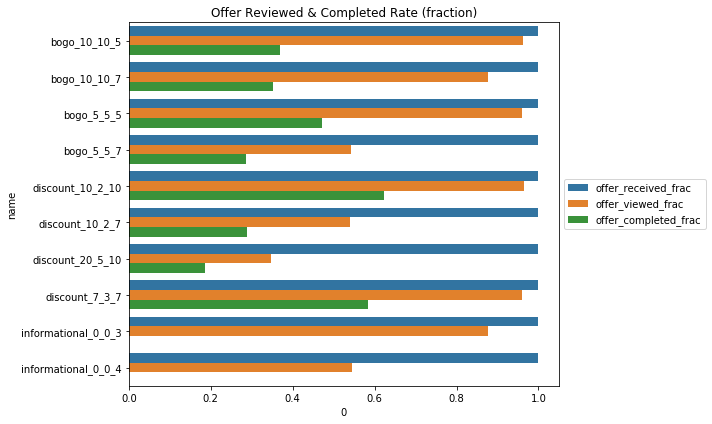

In [356]:
event_count_stack = event_count_frac.stack().reset_index()

plt.figure(figsize=(10,6))
sns.barplot(x=0,y='name', hue='event', data=event_count_stack)
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.subplots_adjust(top=0.8)
plt.title("Offer Reviewed & Completed Rate (fraction)")

plt.tight_layout()

Notes:
- The highest reviewed rate is discount_7_3, followed by bogo_10_10
- The highest completed rate is discount_7_3, followed by discount_10_2

**Action item :**
- need to demean normalize the fraction to show which one is higher or lower

### 3.4. Did every customers received the same portfolio campaign? what is the distribution of customer exposure to portfolio campaign ?

In [65]:
def get_response_time(df, profile_id):
    subset_offer_typ = df[df.event == 'offer completed']['name'].unique().tolist()

    response_time_series = pd.Series(name=profile_id)

    for offer in subset_offer_typ:
        completed_time = df[(df.name == offer) & (df.event == 'offer completed')]['time'].values
        reviewed_time = df[(df.name == offer) & (df.event == 'offer viewed')]['time'].values
        if (completed_time.shape[0] != reviewed_time.shape[0]) and (reviewed_time.shape[0] != 0):
            reviewed_time_clean = np.array([])
            for t in completed_time:
                reviewed_time_clean = np.append(reviewed_time_clean, reviewed_time[reviewed_time <= t].max())
            response_time = completed_time - reviewed_time_clean
        else:
            response_time = completed_time - reviewed_time
            response_time = response_time[response_time > 0]
        
        if response_time.shape[0] != 0 :
            response_time_avg = response_time.mean()
        else:
            response_time_avg = np.nan
        response_time_series[offer +'_' +'response_time_avg'] = response_time_avg
    
    return response_time_series

In [69]:
def get_spending_series(df, profile_id):
    avg_spending = df.amount.mean()
    transaction_count = df.amount.count()
    sum_spending = df.amount.sum()

    spending_series = pd.Series([avg_spending, transaction_count, sum_spending], index=["avg_spending", "transaction_count", 'sum_spending'], name=profile_id)
    return spending_series


In [72]:
def get_offer_typ_series(df, profile_id):
    offer_typ_series = df.offer_type.value_counts()
    offer_typ_series.name = profile_id
    return offer_typ_series

In [76]:
def get_event_typ_series(df, profile_id):
    event_typ_series = (df.event + "_" + df.name).value_counts()
    event_typ_series.name = profile_id
    return event_typ_series

In [115]:
def get_attributes_series(df, profile_id):
    offer_typ_series = get_offer_typ_series(df, profile_id)
    event_typ_series = get_event_typ_series(df, profile_id)
    response_time_series = get_response_time(df, profile_id)
    spending_series = get_spending_series(df, profile_id)
    attributes_series = pd.concat([offer_typ_series,event_typ_series, response_time_series, spending_series], axis=0)
    return attributes_series

In [116]:
def generate_attributes():
    events = ['offer received', 'offer viewed', 'offer completed']
    portfolio_names = [ event +"_"+ name for event in events for name in portfolio.name.tolist() ]
    offer_type_list = portfolio.offer_type.unique().tolist()
    response_time_attributes = [name +'_' +'response_time_avg' for name in portfolio.name.tolist() ]
    attributes = portfolio_names + response_time_attributes + ["avg_spending", "transaction_count"] + offer_type_list
    return attributes



In [117]:
from tqdm import tqdm
attributes_df = pd.DataFrame(index=generate_attributes())

for profile_id in tqdm(transcript_clean.person.unique()):
    subset_df = transcript_clean[transcript_clean.person == profile_id]
    subset_attributes_series = get_attributes_series(subset_df, profile_id)
    attributes_df[profile_id] = subset_attributes_series

100%|██████████| 17000/17000 [07:15<00:00, 39.07it/s]


In [123]:
attributes_df.T.head()

,offer received_bogo_10_10_7,offer received_bogo_10_10_5,offer received_informational_0_0_4,offer received_bogo_5_5_7,offer received_discount_20_5_10,offer received_discount_7_3_7,offer received_discount_10_2_10,offer received_informational_0_0_3,offer received_bogo_5_5_5,offer received_discount_10_2_7,...,discount_7_3_7_response_time_avg,discount_10_2_10_response_time_avg,informational_0_0_3_response_time_avg,bogo_5_5_5_response_time_avg,discount_10_2_7_response_time_avg,avg_spending,transaction_count,bogo,informational,discount
78afa995795e4d85b5d9ceeca43f5fef,1.0,NaN,NaN,1.0,NaN,NaN,NaN,1.0,1.0,NaN,...,NaN,NaN,NaN,NaN,NaN,22.752857,7.0,8.0,2.0,NaN
a03223e636434f42ac4c3df47e8bac43,NaN,NaN,1.0,NaN,3.0,NaN,NaN,1.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,1.550000,3.0,NaN,3.0,5.0
e2127556f4f64592b11af22de27a7932,NaN,NaN,1.0,1.0,NaN,NaN,1.0,NaN,NaN,1.0,...,NaN,NaN,NaN,NaN,NaN,19.243333,3.0,3.0,1.0,5.0
8ec6ce2a7e7949b1bf142def7d0e0586,NaN,1.0,1.0,NaN,NaN,NaN,2.0,NaN,NaN,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,0.0,2.0,2.0,6.0
68617ca6246f4fbc85e91a2a49552598,1.0,1.0,NaN,1.0,NaN,1.0,NaN,NaN,NaN,1.0,...,NaN,NaN,NaN,NaN,NaN,0.120000,2.0,5.0,NaN,4.0


In [130]:
profile_updated = pd.concat([profile.set_index('id'),attributes_df.T ], axis=1, sort=False)
profile_updated.head()

,age,became_member_on,gender,income,offer received_bogo_10_10_7,offer received_bogo_10_10_5,offer received_informational_0_0_4,offer received_bogo_5_5_7,offer received_discount_20_5_10,offer received_discount_7_3_7,...,discount_7_3_7_response_time_avg,discount_10_2_10_response_time_avg,informational_0_0_3_response_time_avg,bogo_5_5_5_response_time_avg,discount_10_2_7_response_time_avg,avg_spending,transaction_count,bogo,informational,discount
68be06ca386d4c31939f3a4f0e3dd783,118,20170212,None,NaN,NaN,NaN,NaN,NaN,1.0,1.0,...,48.0,144.0,NaN,NaN,NaN,2.266667,9.0,NaN,NaN,12.0
0610b486422d4921ae7d2bf64640c50b,55,20170715,F,112000.0,NaN,NaN,1.0,1.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,25.670000,3.0,1.0,1.0,NaN
38fe809add3b4fcf9315a9694bb96ff5,118,20180712,None,NaN,NaN,NaN,NaN,1.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,2.383333,6.0,2.0,2.0,NaN
78afa995795e4d85b5d9ceeca43f5fef,75,20170509,F,100000.0,1.0,NaN,NaN,1.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,22.752857,7.0,8.0,2.0,NaN
a03223e636434f42ac4c3df47e8bac43,118,20170804,None,NaN,NaN,NaN,1.0,NaN,3.0,NaN,...,NaN,NaN,NaN,NaN,NaN,1.550000,3.0,NaN,3.0,5.0


In [131]:
profile_updated.to_csv('profile_updated.csv')

In [141]:
col_null_frac = profile_updated.isnull().sum() / profile_updated.shape[0]
col_null_frac

age                                      0.000000
became_member_on                         0.000000
gender                                   0.127941
income                                   0.127941
offer received_bogo_10_10_7              0.625059
offer received_bogo_10_10_5              0.627647
offer received_informational_0_0_4       0.627588
offer received_bogo_5_5_7                0.626176
offer received_discount_20_5_10          0.625059
offer received_discount_7_3_7            0.627941
offer received_discount_10_2_10          0.627529
offer received_informational_0_0_3       0.628235
offer received_bogo_5_5_5                0.631647
offer received_discount_10_2_7           0.630294
offer viewed_bogo_10_10_7                0.664941
offer viewed_bogo_10_10_5                0.639294
offer viewed_informational_0_0_4         0.786176
offer viewed_bogo_5_5_7                  0.784824
offer viewed_discount_20_5_10            0.858824
offer viewed_discount_7_3_7              0.639882


In [144]:
# cols to fillna with '0' / zero instead of np.nan

cols_to_fillna = ['offer received_bogo_10_10_7',
 'offer received_bogo_10_10_5',
 'offer received_informational_0_0_4',
 'offer received_bogo_5_5_7',
 'offer received_discount_20_5_10',
 'offer received_discount_7_3_7',
 'offer received_discount_10_2_10',
 'offer received_informational_0_0_3',
 'offer received_bogo_5_5_5',
 'offer received_discount_10_2_7',
 'offer viewed_bogo_10_10_7',
 'offer viewed_bogo_10_10_5',
 'offer viewed_informational_0_0_4',
 'offer viewed_bogo_5_5_7',
 'offer viewed_discount_20_5_10',
 'offer viewed_discount_7_3_7',
 'offer viewed_discount_10_2_10',
 'offer viewed_informational_0_0_3',
 'offer viewed_bogo_5_5_5',
 'offer viewed_discount_10_2_7',
 'offer completed_bogo_10_10_7',
 'offer completed_bogo_10_10_5',
 'offer completed_informational_0_0_4',
 'offer completed_bogo_5_5_7',
 'offer completed_discount_20_5_10',
 'offer completed_discount_7_3_7',
 'offer completed_discount_10_2_10',
 'offer completed_informational_0_0_3',
 'offer completed_bogo_5_5_5',
 'offer completed_discount_10_2_7',
 'avg_spending',
 'bogo',
 'informational',
 'discount']

cols_to_drop = col_null_frac[col_null_frac ==1].index.tolist()

In [153]:
profile_updated.columns.tolist()

['age',
 'became_member_on',
 'gender',
 'income',
 'offer received_bogo_10_10_7',
 'offer received_bogo_10_10_5',
 'offer received_informational_0_0_4',
 'offer received_bogo_5_5_7',
 'offer received_discount_20_5_10',
 'offer received_discount_7_3_7',
 'offer received_discount_10_2_10',
 'offer received_informational_0_0_3',
 'offer received_bogo_5_5_5',
 'offer received_discount_10_2_7',
 'offer viewed_bogo_10_10_7',
 'offer viewed_bogo_10_10_5',
 'offer viewed_informational_0_0_4',
 'offer viewed_bogo_5_5_7',
 'offer viewed_discount_20_5_10',
 'offer viewed_discount_7_3_7',
 'offer viewed_discount_10_2_10',
 'offer viewed_informational_0_0_3',
 'offer viewed_bogo_5_5_5',
 'offer viewed_discount_10_2_7',
 'offer completed_bogo_10_10_7',
 'offer completed_bogo_10_10_5',
 'offer completed_bogo_5_5_7',
 'offer completed_discount_20_5_10',
 'offer completed_discount_7_3_7',
 'offer completed_discount_10_2_10',
 'offer completed_bogo_5_5_5',
 'offer completed_discount_10_2_7',
 'bogo_10_

In [151]:
profile_updated[cols_to_fillna] = profile_updated[cols_to_fillna].fillna(0)
profile_updated = profile_updated.drop(cols_to_drop, axis=1)

In [152]:
profile_updated.isnull().sum() /  profile_updated.shape[0]

age                                   0.000000
became_member_on                      0.000000
gender                                0.127941
income                                0.127941
offer received_bogo_10_10_7           0.000000
offer received_bogo_10_10_5           0.000000
offer received_informational_0_0_4    0.000000
offer received_bogo_5_5_7             0.000000
offer received_discount_20_5_10       0.000000
offer received_discount_7_3_7         0.000000
offer received_discount_10_2_10       0.000000
offer received_informational_0_0_3    0.000000
offer received_bogo_5_5_5             0.000000
offer received_discount_10_2_7        0.000000
offer viewed_bogo_10_10_7             0.000000
offer viewed_bogo_10_10_5             0.000000
offer viewed_informational_0_0_4      0.000000
offer viewed_bogo_5_5_7               0.000000
offer viewed_discount_20_5_10         0.000000
offer viewed_discount_7_3_7           0.000000
offer viewed_discount_10_2_10         0.000000
offer viewed_

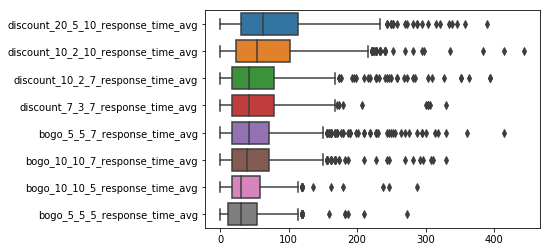

In [195]:
cols = ['bogo_10_10_7_response_time_avg',
 'bogo_10_10_5_response_time_avg',
 'bogo_5_5_7_response_time_avg',
 'discount_20_5_10_response_time_avg',
 'discount_7_3_7_response_time_avg',
 'discount_10_2_10_response_time_avg',
 'bogo_5_5_5_response_time_avg',
 'discount_10_2_7_response_time_avg']

order = profile_updated[cols].mean().sort_values(ascending=False).index
sns.boxplot(data=profile_updated[cols], orient='h', order=order);

In [208]:
profile_portfolio = profile_updated[cols].stack().reset_index().drop('level_0', axis=1)
profile_portfolio.columns = ['portfolio', 'response_time_avg']
profile_portfolio['portfolio'] = profile_portfolio['portfolio'].apply(lambda x: x[:-18])
profile_portfolio.head()

,portfolio,response_time_avg
0,discount_7_3_7,48.0
1,discount_10_2_10,144.0
2,bogo_10_10_7,102.0
3,bogo_5_5_7,126.0
4,bogo_5_5_7,102.0


In [212]:
profile_response_time = pd.merge(profile_portfolio, portfolio, left_on='portfolio', right_on='name', how='left').drop(['portfolio'], axis=1)
profile_response_time.head()

,response_time_avg,difficulty,duration,id,offer_type,reward,name,web,email,mobile,social
0,48.0,7,7,2298d6c36e964ae4a3e7e9706d1fb8c2,discount,3,discount_7_3_7,1,1,1,1
1,144.0,10,10,fafdcd668e3743c1bb461111dcafc2a4,discount,2,discount_10_2_10,1,1,1,1
2,102.0,10,7,ae264e3637204a6fb9bb56bc8210ddfd,bogo,10,bogo_10_10_7,0,1,1,1
3,126.0,5,7,9b98b8c7a33c4b65b9aebfe6a799e6d9,bogo,5,bogo_5_5_7,1,1,1,0
4,102.0,5,7,9b98b8c7a33c4b65b9aebfe6a799e6d9,bogo,5,bogo_5_5_7,1,1,1,0


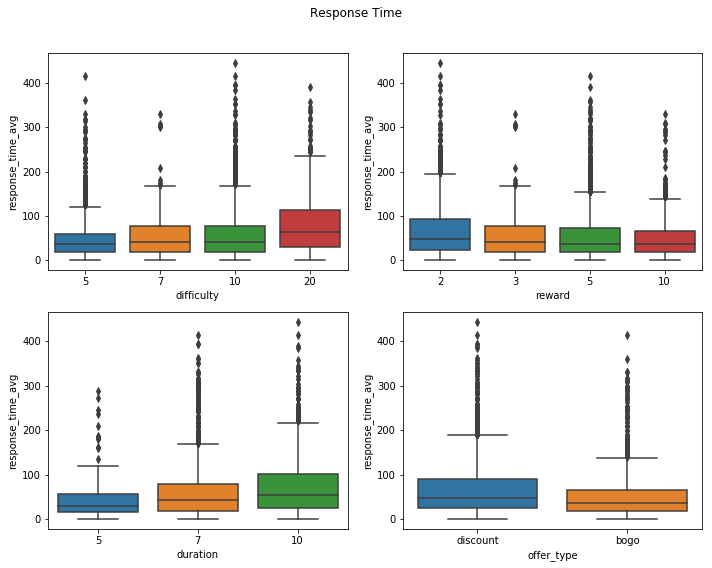

In [245]:
f, ((ax1,ax2), (ax3, ax4)) = plt.subplots(2,2, figsize=(10,8))

sns.boxplot(x="difficulty", y='response_time_avg', data= profile_response_time, ax=ax1)
sns.boxplot(x="reward", y='response_time_avg', data= profile_response_time, ax=ax2)
sns.boxplot(x="duration", y='response_time_avg', data= profile_response_time, ax=ax3)
sns.boxplot(x="offer_type", y='response_time_avg', data= profile_response_time, ax=ax4)

f.suptitle('Response Time')
f.tight_layout()
f.subplots_adjust(top=0.9)

Notes:
- Bogo has lower response time (faster) than discount
- the higher the difficulty and duration, the higher response time (slower)
- the higher the reward, the lower response time (faster)

In [247]:
profile_updated.head()

,age,became_member_on,gender,income,offer received_bogo_10_10_7,offer received_bogo_10_10_5,offer received_informational_0_0_4,offer received_bogo_5_5_7,offer received_discount_20_5_10,offer received_discount_7_3_7,...,discount_20_5_10_response_time_avg,discount_7_3_7_response_time_avg,discount_10_2_10_response_time_avg,bogo_5_5_5_response_time_avg,discount_10_2_7_response_time_avg,avg_spending,transaction_count,bogo,informational,discount
68be06ca386d4c31939f3a4f0e3dd783,118,20170212,None,NaN,0.0,0.0,0.0,0.0,1.0,1.0,...,NaN,48.0,144.0,NaN,NaN,2.266667,9.0,0.0,0.0,12.0
0610b486422d4921ae7d2bf64640c50b,55,20170715,F,112000.0,0.0,0.0,1.0,1.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,25.670000,3.0,1.0,1.0,0.0
38fe809add3b4fcf9315a9694bb96ff5,118,20180712,None,NaN,0.0,0.0,0.0,1.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,2.383333,6.0,2.0,2.0,0.0
78afa995795e4d85b5d9ceeca43f5fef,75,20170509,F,100000.0,1.0,0.0,0.0,1.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,22.752857,7.0,8.0,2.0,0.0
a03223e636434f42ac4c3df47e8bac43,118,20170804,None,NaN,0.0,0.0,1.0,0.0,3.0,0.0,...,NaN,NaN,NaN,NaN,NaN,1.550000,3.0,0.0,3.0,5.0


In [249]:
profile_updated.isnull().sum() / profile_updated.shape[0]

age                                   0.000000
became_member_on                      0.000000
gender                                0.127941
income                                0.127941
offer received_bogo_10_10_7           0.000000
offer received_bogo_10_10_5           0.000000
offer received_informational_0_0_4    0.000000
offer received_bogo_5_5_7             0.000000
offer received_discount_20_5_10       0.000000
offer received_discount_7_3_7         0.000000
offer received_discount_10_2_10       0.000000
offer received_informational_0_0_3    0.000000
offer received_bogo_5_5_5             0.000000
offer received_discount_10_2_7        0.000000
offer viewed_bogo_10_10_7             0.000000
offer viewed_bogo_10_10_5             0.000000
offer viewed_informational_0_0_4      0.000000
offer viewed_bogo_5_5_7               0.000000
offer viewed_discount_20_5_10         0.000000
offer viewed_discount_7_3_7           0.000000
offer viewed_discount_10_2_10         0.000000
offer viewed_

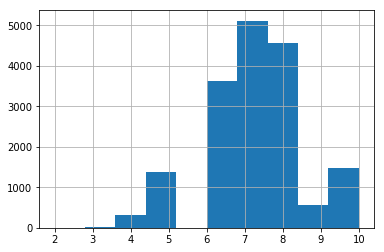

In [257]:
row_null = profile_updated.isnull().sum(axis=1) #/ profile_updated.shape[0]
row_null.hist();

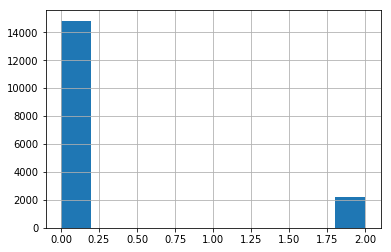

In [258]:
row_null = profile_updated.drop(cols, axis=1).isnull().sum(axis=1) #/ profile_updated.shape[0]
row_null.hist();